# Библиотеки

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

# Matplotlib и plotly
import matplotlib.pyplot as plt
import plotly.express as px

# cv2
import cv2

# OS
import os
import argparse
from tqdm.auto import tqdm

import random
from typing import Dict, List, Optional, Tuple
from IPython.display import clear_output

# Модель

In [ ]:
train_dataset = CIFAR10(root="./", train=True, download=True)
test_dataset = CIFAR10(root="./", train=False, download=True)

100%|██████████| 170M/170M [00:16<00:00, 10.4MB/s]


In [ ]:
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
    train_data = train_data / 255.0
    train_data = np.expand_dims(train_data, axis=3)
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
        test_data = test_data / 255.0
        train_data = np.expand_dims(train_data, axis=3)
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data

def load_CIFAR10(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = CIFAR10(root="./", train=is_train, download=False)
    train_data = train_dataset.data

    if with_targets:
        train_labels = np.array(train_dataset.targets)
        return train_data, train_labels

    return train_data

def load_dataset(
    is_train: bool = True,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels = load_CIFAR10(with_targets=True, is_train=is_train)
    train_data = train_data.astype("float32")

    train_data = prepare_images(train_data)

    if classes is not None:
        train_mask = np.isin(train_labels, classes)
        train_data = train_data[train_mask]

    return train_data

def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [ ]:
from typing import Dict, Optional, Tuple, Union

from matplotlib.axes import Axes
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_score,
    recall_score,
    roc_auc_score,
)

def _plot_precision_and_recall_curves(
    y_true: Union[pd.Series, np.ndarray], y_score: Union[pd.Series, np.ndarray], ax: Optional[Axes] = None
) -> None:
    """Метод по отрисовке графиков Precision, Recall и mean_prediction в зависимости от пороговых значений для скора

    Args:
        y_true: фактические метки классов тестовой выборки
        y_score: посчитанные скоры для тестовой выборки
        ax: объект класса Axes для отрисовки графика
    """
    if ax is None:
        _, ax = plt.subplots()

    thresholds = np.linspace(0.01, 0.99, 200)

    precision = []
    recall = []
    proportion = []
    for threshold in thresholds:
        threshold_preds = (y_score > threshold).astype(int)
        precision.append(precision_score(y_true, threshold_preds, zero_division=0))
        recall.append(recall_score(y_true, threshold_preds, zero_division=0))
        proportion.append(threshold_preds.mean())
        # if y_true.mean() / threshold_preds.mean() <= 1:
        #     proportion.append(y_true.mean() / threshold_preds.mean())

    ax.plot(thresholds, precision, "-r", label="precision")
    ax.plot(thresholds, recall, "-.b", label="recall")
    ax.plot(thresholds[: len(proportion)], proportion, "--g", label="mean prediction")

    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    ax.grid(which="both", axis="both", visible=True)
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)

    ax.set_xlabel("threshold")
    ax.set_ylabel("metrics")
    ax.set_title("Precision and Recall curves")
    ax.legend(
        fontsize=8.5,
        title="",
        frameon=False,
        bbox_to_anchor=(0, -1.15, 1, 1),
        loc="upper center",
        mode="expand",
        ncol=3,
    )

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # self.encoder = nn.Linear(1024, 256)
        # self.decoder = nn.Linear(256, 1024)
        self.encoder = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.decoder = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        # x = x.view(-1, 1024)
        x = x.view(-1, 1, 32, 32)
        x_encoded = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x_encoded))
        x = x.view(-1, 1, 32, 32)
        return x_encoded, x

In [ ]:
# Set random seed for reproducibility
# SEED = 87
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)

def create_model():
    autoencoder = Autoencoder()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
    return autoencoder


def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Дополнительные функции

In [ ]:
def sample_data(data: np.ndarray, num_elements: int) -> np.ndarray:
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data(classes: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    class_1_data = load_dataset(is_train=True, classes = classes[0])
    class_2_data = load_dataset(is_train=True, classes = classes[1])

    train_1_data = sample_data(class_1_data, 2000).reshape((-1, 1, 32, 32))
    train_2_data = sample_data(class_2_data, 2000).reshape((-1, 1, 32, 32))

    return train_1_data, train_2_data

# MSE, таргет -- доли классов в датасете

In [ ]:
def train_model(train_loader, epochs):
    autoencoder = create_model()
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(autoencoder.parameters())
    for epoch in range(epochs):
        running_loss = 0.0
        for i, inputs in enumerate(train_loader, 0):
            inputs = get_torch_vars(inputs)

            # ============ Forward ============
            encoded, outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return autoencoder

In [ ]:
# Среднее по тестовой выборке
def get_vector(model, test_loader):
    model.eval()
    all_encoded_outputs = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            encoded_output, _ = model(batch.to("cuda"))
            all_encoded_outputs.append(encoded_output)

    all_encoded_outputs = torch.cat(all_encoded_outputs, dim=0)
    mean_encoded_output = torch.mean(all_encoded_outputs, dim=0)
    return mean_encoded_output

# Вектор параметров модели
def get_vector(model, test_loader):
    model.eval()
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    return torch.cat(params)

# Вектор линейного слоя энкодера
def get_vector(model, test_loader):
    model.eval()
    last_layer = model.encoder[-1]
    weights = last_layer.weight.view(-1)
    return weights


# Сингулярные числа
def extract_singular_values_from_layer(weight_tensor):
    if len(weight_tensor.shape) == 4:
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    return S

def extract_singular_values_from_encoder(weights):
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model):
    weights = []
    for layer in [model.encoder]:
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    for layer in [model.decoder]:
        if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    singular_values_list = extract_singular_values_from_encoder(weights)
    return np.concatenate(singular_values_list)

# Распределение весов слоёв модели
# def trim_quantiles(weights, lower_quantile=0.01, upper_quantile=0.99):
#     lower_bound = torch.quantile(weights, lower_quantile)
#     upper_bound = torch.quantile(weights, upper_quantile)
#     trimmed_weights = torch.clamp(weights, lower_bound, upper_bound)
#     return trimmed_weights

# def get_vector(model, num_bins=20):
#     weights = []
#     for layer in [model.encoder]:
#         if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#             weight = trim_quantiles(layer.weight.data)
#             weights.append(weight.cpu().detach().numpy().flatten())
#     for layer in [model.decoder]:
#         if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
#             weight = trim_quantiles(layer.weight.data)
#             weights.append(weight.cpu().detach().numpy().flatten())

#     binned_weights = []
#     for weight in weights:
#         hist, bin_edges = np.histogram(weight, bins=num_bins, density=True)
#         binned_weights.append(hist)
#     return np.concatenate(binned_weights)

In [ ]:
num_models_train = 300
num_models_test = 100
num_epochs = 20
batch_size = 32

classes = [5, 8]

def train_autoencoders(num_models: int, num_epochs: int, batch_size: int):
    vectors_1 = []
    vectors_2 = []
    # data_1 = []
    # data_2 = []
    for i in tqdm(range(num_models)):
        train_1_data, train_2_data = get_data(classes)
        # data_1.append(train_1_data)
        # data_2.append(train_2_data)
        for i, train_data in enumerate((train_1_data, train_2_data)):
            train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
            model = train_model(train_loader, num_epochs)
            vector = get_vector(model)
            if i == 0:
                vectors_1.append(vector)
            else:
                vectors_2.append(vector)
    return vectors_1, vectors_2

vectors_1, vectors_2 = train_autoencoders(num_models_train, num_epochs, batch_size)
vectors_1_test, vectors_2_test = train_autoencoders(num_models_test, num_epochs, batch_size)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.save('vectors_1.npy', vectors_1)
np.save('vectors_2.npy', vectors_2)
np.save('vectors_1_test.npy', vectors_1_test)
np.save('vectors_2_test.npy', vectors_2_test)

In [ ]:
vectors_1_1 = np.load('vectors_1.npy')
vectors_2_1 = np.load('vectors_2.npy')
vectors_1_test_1 = np.load('vectors_1_test.npy')
vectors_2_test_1 = np.load('vectors_2_test.npy')

In [ ]:
def train_encoder(model, train_loader, epochs, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        count = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ============ Logging ============
            running_loss += loss.data
            count += 1
        # print(outputs, labels)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / count:.4f}")
        running_loss = 0.0
        count = 0
    return model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        # self.softmax = nn.Softmax(dim=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # batch_size = x.shape[0]
        x = self.encoder(x)
        # x = self.softmax(x)
        # x = self.encoder(x[mask.repeat(2, 1)].view((batch_size, -1)))
        # x = self.softmax(x.view((batch_size, -1)))
        # x = self.sigmoid(x)
        return x

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, class_1, class_2, transform=None):
        self.vectors = list(class_1) + list(class_2)
        self.labels = [0] * len(class_1) + [1] * len(class_2)

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vectors[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return vector, label

In [ ]:
train_dataset = CustomDataset(vectors_1, vectors_2)
test_dataset = CustomDataset(vectors_1_test, vectors_2_test)

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
epochs = 10
device = "cpu"

encoder = Encoder(vectors_1[0].size, 64, 2).to(device)
encoder = train_encoder(encoder, train_loader, epochs, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.6950
Epoch 2/10, Loss: 0.6945
Epoch 3/10, Loss: 0.6908
Epoch 4/10, Loss: 0.6883
Epoch 5/10, Loss: 0.6874
Epoch 6/10, Loss: 0.6842
Epoch 7/10, Loss: 0.6856
Epoch 8/10, Loss: 0.6797
Epoch 9/10, Loss: 0.6812
Epoch 10/10, Loss: 0.6783


In [ ]:
encoder.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for i, (batch, label) in enumerate(test_loader):
        outputs = encoder(batch.to(device))
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        all_labels.extend(label.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [ ]:
# Свёрточные слои
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       100
           1       0.63      0.37      0.47       100

    accuracy                           0.57       200
   macro avg       0.59      0.57      0.56       200
weighted avg       0.59      0.57      0.56       200



In [ ]:
# Линейные слои
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       100
           1       1.00      0.74      0.85       100

    accuracy                           0.87       200
   macro avg       0.90      0.87      0.87       200
weighted avg       0.90      0.87      0.87       200



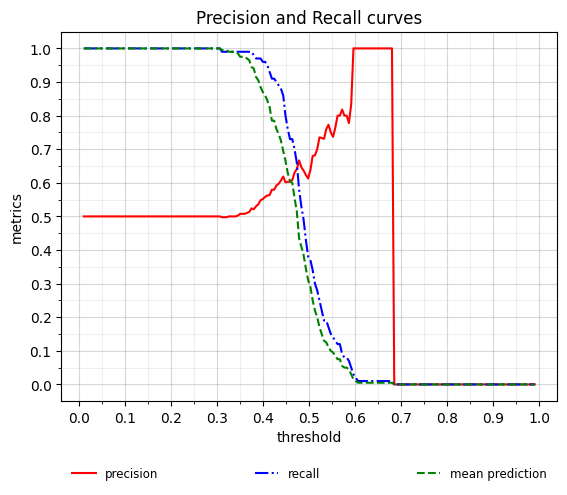

In [ ]:
_plot_precision_and_recall_curves(all_labels, all_probs)